### Load in DESeq2 Results

As mentioned, I ran DESeq2 in a separate notebook. I ran two tests, one that just compares every stim to the control for every non-zero time point (labeled by the hour in the cell below), and another that tries to model stimulation-specific changes over time (labeled as TC below). I'll read in all, but since I'm not *exactly* sure how to interpret the latter, I'm really only going to focus on the former in this notebook.

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy

And then some from the [goatools](https://github.com/tanghaibao/goatools) Gene Ontology package for Python. Most of the code here modeled after the [notebooks](https://github.com/tanghaibao/goatools#ipython-notebooks) found on the Github.

In [2]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_hum
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [3]:
prefix = '/data/codec/production.run/mrna/'

In [4]:
conds_1 = ['A', 'B', 'G', 'P', 'R']
cts_1 = ['B_Memory', 'B_Naive', 'CD4_T_Memory', 'CD4_T_Naive', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Naive', 'HSC', 'NK', 'pDC','Mono_cDC_All']

Read in the results.

In [5]:
de = dict() # differential expression dictionary
for cond in conds_1:
    de[cond] = dict()
    
combos = it.product(conds_1, cts_1)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

In [6]:
conds_2 = ['A', 'B', 'G', 'R']
cts_2 = ['Mono_C', 'Mono_NC', 'cDC']

In [7]:
combos = it.product(conds_2, cts_2)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

### Plot The Positive Half of the Volcano Plot for Any Sample

Just focusing on those genes that were increased in expression relatively to control.

In [8]:
stim = 'R'
ct = 'B_Memory'

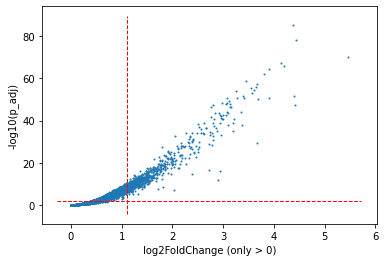

In [9]:
df = de[cond][ct]
df = df[df['log2FoldChange'] > 0]
fc_thresh = np.percentile(df['log2FoldChange'],90)

plt.scatter(df['log2FoldChange'].values, 
            -np.log10(df['padj']).values,
           s=1);

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()


#########################################################################################################
# Through testing with multiple samples, I think a good metric for determining differentially expressed genes involves a strict p_adj value cutoff (0.05) 
# and a dynamic log fold change threshold that changes depending on the sample. I'm using the log2foldchange value at the 90th %ile of positive values
#########################################################################################################

# drawing cutoffs here
plt.plot(xlim, [-np.log10(0.01)]*2, linewidth=1, c='r', linestyle='--');
plt.plot([fc_thresh]*2, ylim, linewidth=1, c='r', linestyle='--');

plt.xlabel('log2FoldChange (only > 0)')
plt.ylabel('-log10(p_adj)');

### Get Pseudobulks

In [10]:
pseudobulk = pd.read_pickle(prefix + 'pkls/aggr/pseudobulk.cts.pkl')
# this object is a pseudobulk (sum) over all the cells in a particular condition in a particular condition
# summing makes sense over all the cells, but to get a measure of centrality for each condition-cell type, I will take the *mean* of individuals

In [11]:
ct_cond_combos = list(it.product(cts_1, conds_1)) + list(it.product(cts_2, conds_2))

In [12]:
pseudobulk_conds_cts_list = list()
for ct, cond in tqdm(ct_cond_combos):
    mean_ind = pseudobulk[(pseudobulk['CT'] == ct) & (pseudobulk['COND'] == cond)].iloc[:,3:].mean(0).values.tolist()
    pseudobulk_conds_cts_list.append([ct, cond] +  mean_ind)

In [13]:
pseudobulk_conds_cts = pd.DataFrame(pseudobulk_conds_cts_list, columns = ['CT', 'COND'] + pseudobulk.columns.tolist()[3:])

In [14]:
# Just confirm that no genes have counts of zero.
(pseudobulk_conds_cts.iloc[:,2:].sum(0) == 0).sum() == 0

True

## DE Genes: 2-sided, Static Cutoffs

Using a static cutoff for LFC and strict p_adj < 0.01, I will now extract out differentially expressed genes. At Hyun's suggestion, using only the top _n_ significant genes from each comparison, since some conditions like PMAI and R848 have 1000s, while TNF-alpha conditions have in the 10s or 100. Using the top 200 from each condition will not bias the heatmap towards the most stimulating conditions.

In [174]:
de_genes = dict() # make a dictionary

num_top_genes_to_keep = 200
for ct, cond in ct_cond_combos: 
    try:
        de_genes[ct]
    except KeyError:
        de_genes[ct] = dict()

    df = de[cond][ct] # get the DE results
    df = df[(df['log2FoldChange'] > 2) | (df['log2FoldChange'] < -2)]
    
    # extract out genes, add them to the dictionary as a list
    df_significant = df[(df['padj'] < 0.05)]
    de_genes[ct][cond] = df.sort_values('padj').index[:num_top_genes_to_keep]

all_de_genes = list()
lengths = list()
for ct, cond in ct_cond_combos:
    de_genes_list = de_genes[ct][cond]
    length = len(de_genes_list)
    lengths.append(length)
#     print((ct, cond, length))
    all_de_genes.append(de_genes[ct][cond])

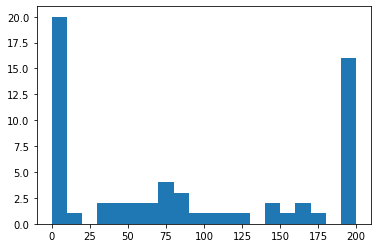

In [175]:
plt.hist(lengths, bins=20);

In [176]:
all_de_genes = np.unique([i for j in all_de_genes for i in j])

Turn the counts matrix into an adata object for easy processing like normalize, log1p, and scaling.

In [177]:
counts_for_heatmap = pseudobulk_conds_cts.iloc[:,2:]
obs = pd.DataFrame(index=pseudobulk_conds_cts['CT'] + '-' + pseudobulk_conds_cts['COND'])
var = pd.DataFrame(index=pseudobulk_conds_cts.iloc[:,2:].columns)

In [178]:
adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

In [179]:
adata

AnnData object with n_obs × n_vars = 62 × 20303

In [180]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [181]:
adata.raw = adata.copy()

In [182]:
sc.pp.log1p(adata)

In [183]:
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [184]:
df_de = pd.DataFrame(adata[:,all_de_genes].X, index=obs.index, columns=all_de_genes)

In [185]:
df_de.shape

(62, 1583)

## Plotting

### Clustering by Tree Cut

#### Naive Coloring

Better to separately make the linkage matrix, becuase I'm going to want to cluster the genes based on it.

In [27]:
Z = scipy.cluster.hierarchy.linkage(df_de.T, method='average', optimal_ordering=True)

Gotta love scanpy's colors:

In [28]:
num_modules = 100
color_dict = dict(zip(range(num_modules),sc.pl.palettes.default_102))

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


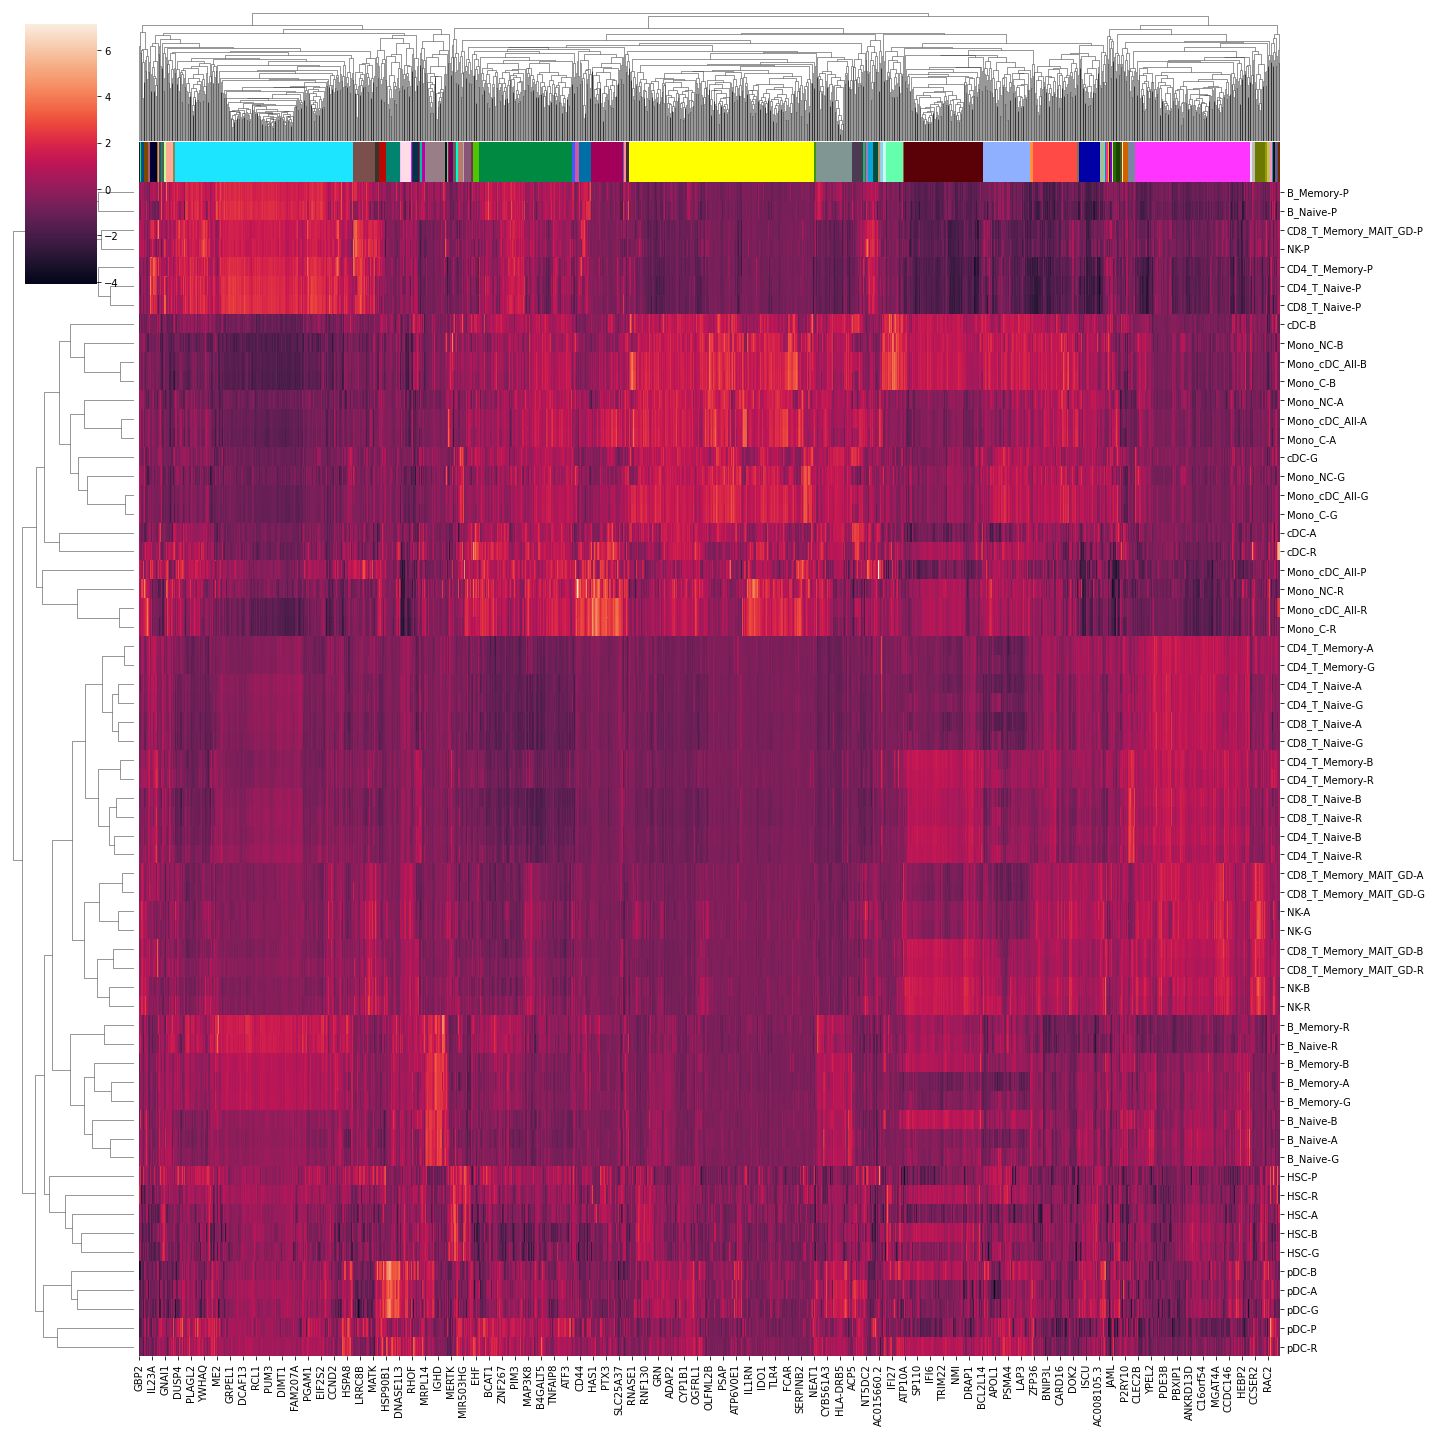

In [29]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()
sns.clustermap(df_de, figsize=(20,20), 
               row_cluster=True,
               col_linkage=Z, 
               col_colors=list(map(lambda x: color_dict[x], modules)),
               dendrogram_ratio=0.1,
              );
# plt.tight_layout()

#### Get Labels and Color according to Size

In [30]:
# credit to user Has QUIT--Anony-Mousse from https://stackoverflow.com/questions/12572436/calculate-ordering-of-dendrogram-leaves
n = len(Z) + 1
cache = dict()
for k in range(len(Z)):
    c1, c2 = int(Z[k][0]), int(Z[k][1])
    c1 = [c1] if c1 < n else cache.pop(c1)
    c2 = [c2] if c2 < n else cache.pop(c2)
    cache[n+k] = c1 + c2
ordering = cache[2*len(Z)]

In [31]:
# cmap = mpl.cm.get_cmap('prism')

In [32]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()[ordering]

In [33]:
module_vals, module_counts = np.unique(modules, return_counts=True)

In [34]:
modules_size_ordered = pd.DataFrame(data=zip(module_vals, module_counts),
                                    columns=['v','c']).sort_values('c', ascending=False)['v'].values

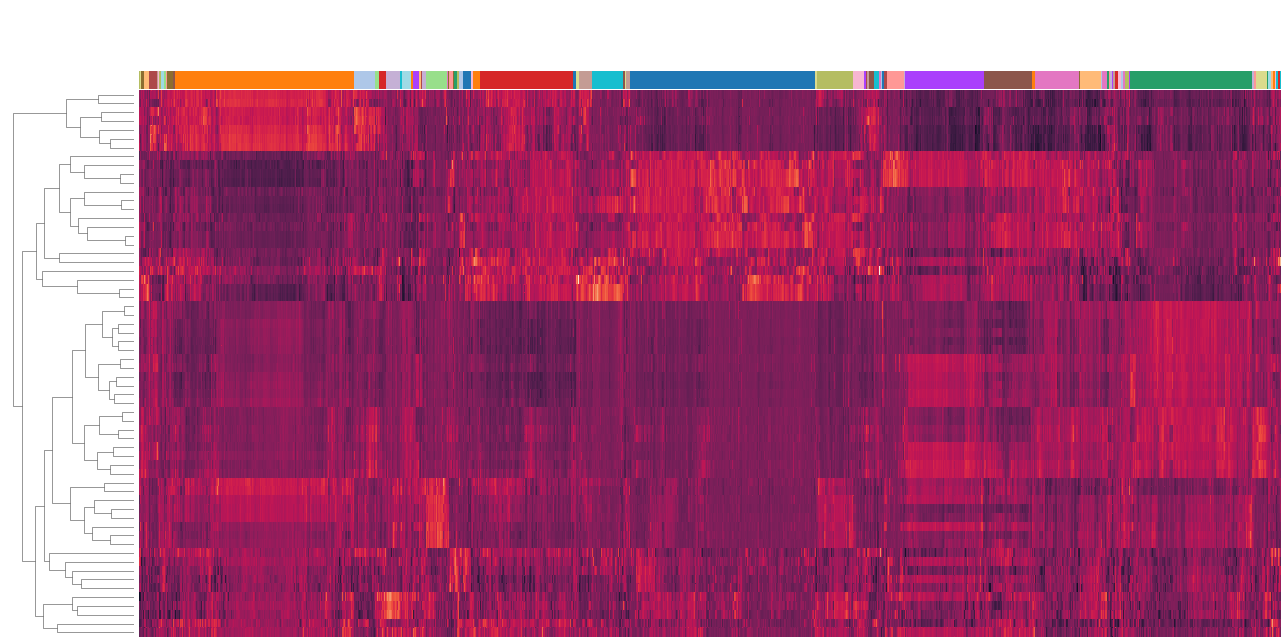

In [35]:
color_dict = dict(zip(modules_size_ordered,sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))))
genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

#### Module Identification

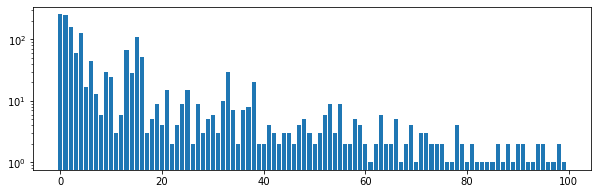

In [36]:
plt.figure(figsize=(10,3))
plt.bar(module_vals, module_counts);#, s=5);
plt.yscale('log');

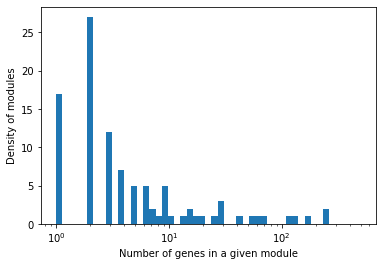

In [37]:
plt.hist(module_counts, bins=np.logspace(np.log10(1), np.log10(500), 50));
plt.xscale('log')
plt.xlabel('Number of genes in a given module')
plt.ylabel('Density of modules');

Only want to keep the main modules:

In [38]:
main_modules = np.arange(num_modules)[module_counts > 5]
main_modules_genes = dict()
for module in main_modules:
    main_modules_genes[module] = genes[modules == module]

In [39]:
len(main_modules_genes)

32

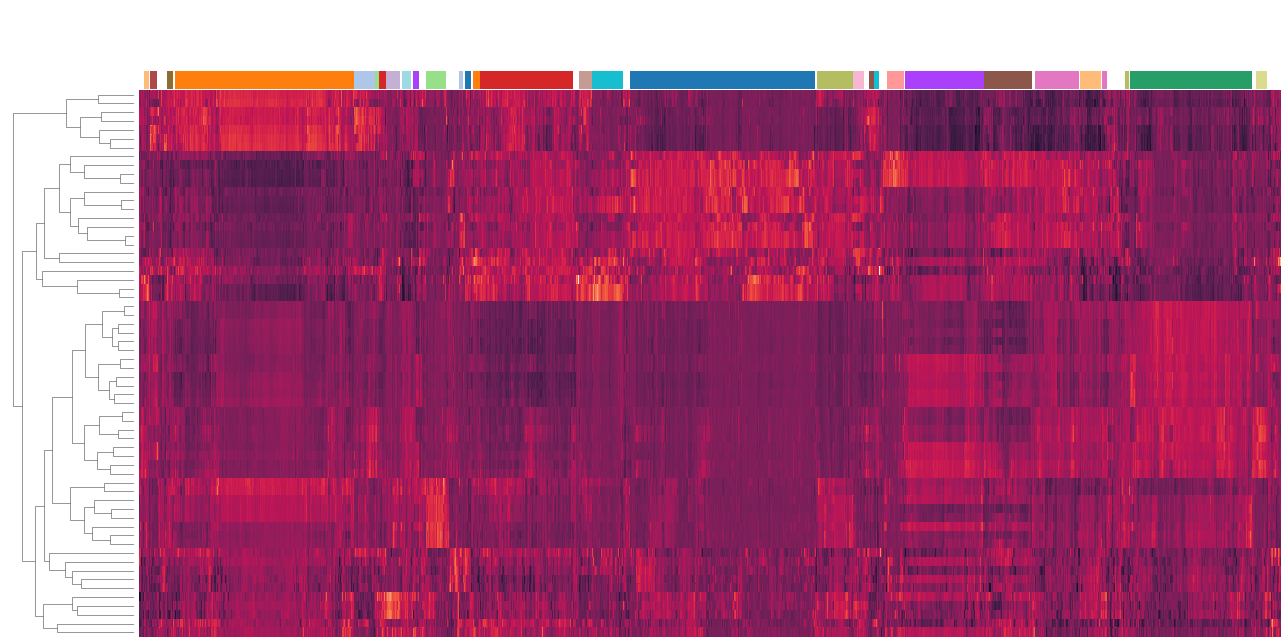

In [40]:
colorful_colors = sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))
colors = colorful_colors[:len(main_modules_genes)] + ['#FFFFFF']*(num_modules-len(main_modules_genes))
color_dict = dict(zip(modules_size_ordered, colors))

genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

Visualize the colors for the modules.

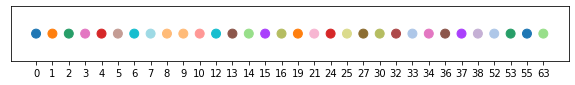

In [41]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

### Clustering by KMeans

In [42]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

Code for finding optimal k taken from [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

In [43]:
distortions = list()
K = np.concatenate(([1],np.arange(5,105,5)))
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(df_de.T)
    kmeanModel.fit(df_de.T)
    distortions.append(sum(np.min(cdist(df_de.T, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_de.T.shape[0])

In [44]:
rise = [distortions[i] - distortions[i - 1] for i in range(1, len(K))]
run = [K[i] - K[i - 1] for i in range(1, len(K))]
slopes = np.array([-i/j for i, j in zip(rise, run)])

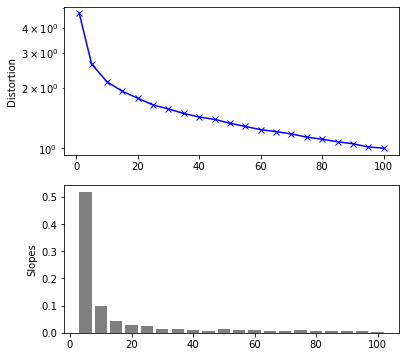

In [45]:
# Plot the elbow
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(K, distortions - min(distortions) + 1, 'bx-')
ax[0].set_ylabel('Distortion')
ax[0].set_yscale('log')
ax[1].bar(K[1:], slopes, width=4, color='k', alpha=0.5)
ax[1].set_ylabel('Slopes');

In [46]:
n_clusts = 30
kmeans = KMeans(n_clusters=n_clusts).fit(df_de.T)

Gotta love scanpy's colors:

In [47]:
color_dict = dict(zip(range(n_clusts),sc.pl.palettes.default_20*2))

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


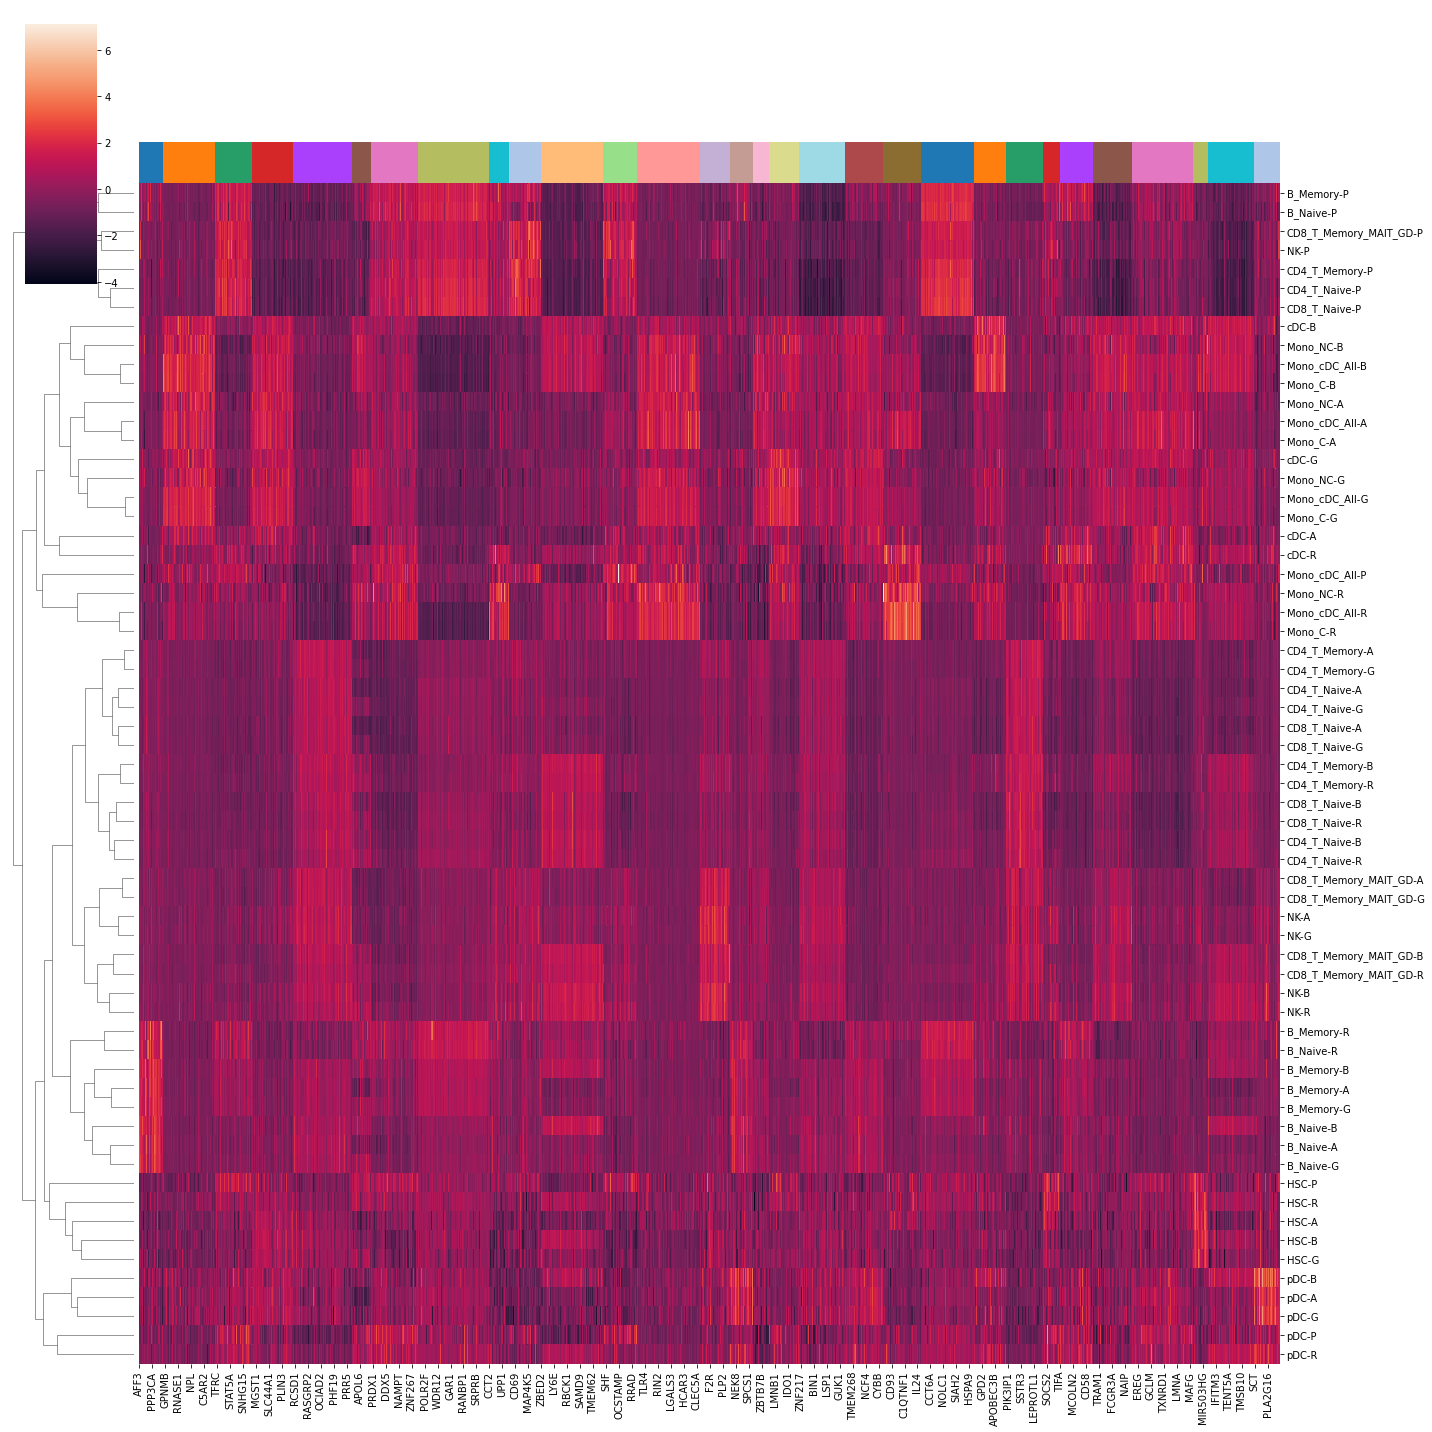

In [48]:
cg = sns.clustermap(df_de.iloc[:,np.argsort(kmeans.labels_)], figsize=(20,20), 
                    row_cluster=True,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    dendrogram_ratio=0.1,
                   );
# plt.tight_layout()

In [49]:
ordered_cts = [i.split('-')[0] for i in df_de.index]
ordered_conds = [i.split('-')[1] for i in df_de.index]

In [50]:
import pickle as pkl

In [51]:
with open(prefix + '../cond.colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

In [52]:
with open(prefix + '../ct.colors.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['hex']

In [53]:
np.setdiff1d(np.unique(ordered_cts), np.array(list(ct_colors.keys())))

array(['Mono_cDC_All'], dtype='<U20')

In [54]:
ct_colors['Mono_cDC_All'] = '#808080' # make it gray

At Jimmie's suggestion, I'm going to make an additional column color to compare the genes that were found differentially expressed in the bulk.

In [55]:
with open(prefix + '../../bulk.jan20/kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'rb') as file:
    bulk_main_modules_genes = pkl.load(file)
    bulk_main_modules_genes = np.unique(np.concatenate([i for i in bulk_main_modules_genes.values()]))

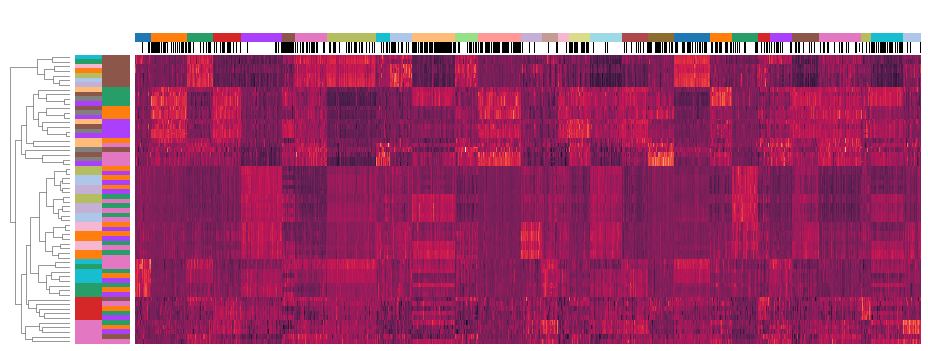

In [56]:
bulk_color = {True: '#000000',
              False: '#FFFFFF'
             }
cg = sns.clustermap(df_de.iloc[:,np.argsort(kmeans.labels_)], figsize=(15,6), 
                    row_cluster=True,
                    col_cluster=False,
                    col_colors=[list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                                list(map(lambda x: bulk_color[x], 
                                         [i in bulk_main_modules_genes for i in df_de.columns[np.argsort(kmeans.labels_)]]))
                               ],
                    row_colors=[list(map(lambda x: ct_colors[x], ordered_cts)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))
                               ],
                    dendrogram_ratio=0.07,
                    cbar_pos=None);
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

Wow, that looks _substantially_ better than hierarchical clustering. KMeans it is. Put them into modules.

In [57]:
main_modules = np.arange(n_clusts)
main_modules_genes = dict(zip(main_modules, [df_de.columns[kmeans.labels_ == i].values for i in range(n_clusts)]))

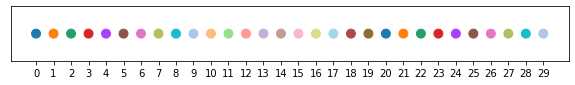

In [58]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

### Adding Rows for Bulk and Pseudobulk

In [186]:
with open(prefix + 'pkls/aggr/pseuobulk.conds.inds.norm.pkl', 'rb') as file:
    pseudobulk_cond_inds_norm = pkl.load(file)
with open(prefix + '../../bulk.jan20/counts.norm.pkl', 'rb') as file:
    bulk_cond_inds_norm = pkl.load(file)

Are all the differentially expressed genes at least *found* in the bulk dataset (i.e. the gene all have the same name and were annotated in the bulk pipeline)? For the pseudobulk, the next cell should definitely pass, since all gene names in df_de should be a subset of those in pseudobulk_cond_inds_norm. But for the bulk it might not.

In [187]:
pseudobulk_cond_inds_norm = pseudobulk_cond_inds_norm[['COND', 'IND'] + df_de.columns.tolist()].copy()
bulk_cond_inds_norm = bulk_cond_inds_norm[['COND', 'IND'] + df_de.columns.tolist()].copy()

Ahh that's nice. Worked for bulk.

In [191]:
cond_inds_norm_means = dict()

In [192]:
for label, df in zip(['p', 'b'], [pseudobulk_cond_inds_norm, bulk_cond_inds_norm]):
    means = list()
    
    for cond in tqdm(['A', 'B', 'G', 'P', 'R']):
        means.append(df[df['COND'] == cond].mean()[1:].tolist())
    
    df = pd.DataFrame(means, 
                      index = [i + '_' + label for i in ['A', 'B', 'G', 'P', 'R']],
                      columns = df.columns[2:]
                     )
    obs = pd.DataFrame(index=df.index)
    var = pd.DataFrame(index=df.columns)
    adata = sc.AnnData(X=df.values, obs=obs, var=var)
    adata.var_names_make_unique()
    
    # They've already been normed soo....
#     sc.pp.normalize_total(adata, target_sum=1e6) 
    
#     cond_inds_norm_means[label] = pd.DataFrame(adata.X, index=obs.index, columns=var.index)
    cond_inds_norm_means[label] = adata

In [201]:
counts_for_heatmap = pseudobulk_conds_cts.iloc[:,2:]
obs = pd.DataFrame(index=pseudobulk_conds_cts['CT'] + '-' + pseudobulk_conds_cts['COND'])
var = pd.DataFrame(index=pseudobulk_conds_cts.iloc[:,2:].columns)

adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e6)

In [202]:
adata = adata.concatenate(cond_inds_norm_means['p'], cond_inds_norm_means['b'])

In [203]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [212]:
df_de_bulk_compare = pd.DataFrame(adata[:,all_de_genes].X, index=adata.obs_names, columns=adata.var_names)

In [228]:
label_ordering = df_de_bulk_compare.iloc[:,np.argsort(kmeans.labels_)]
only_pb_compare = label_ordering.loc[[i for i in df_de_bulk_compare.index if '_p' in i or '_b' in i],:].sort_index()

In [234]:
ordered_conds = [i.split('_')[0] for i in only_pb_compare.index]
ordered_type = [i.split('_')[1].split('-')[0] for i in only_pb_compare.index]

In [233]:
print(ordered_cts)
print(ordered_type)

['A', 'A', 'B', 'B', 'G', 'G', 'P', 'P', 'R', 'R']
['b', 'p', 'b', 'p', 'b', 'p', 'b', 'p', 'b', 'p']


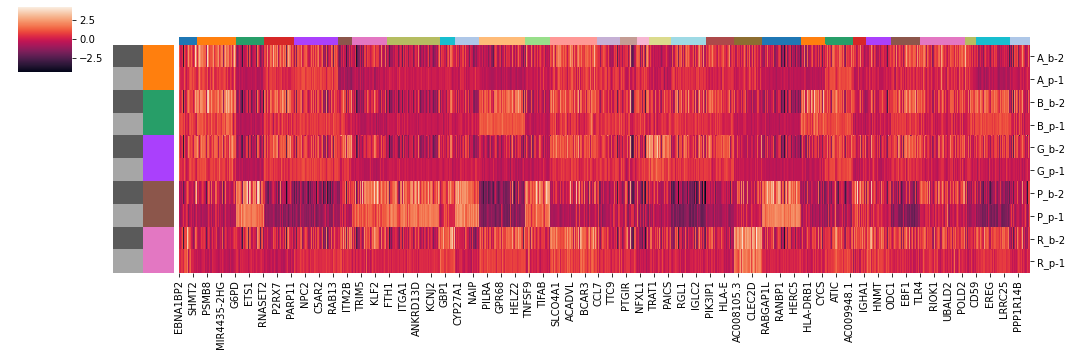

In [236]:
cg = sns.clustermap(only_pb_compare, 
                    figsize=(15,5), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    row_colors=[list(map(lambda x: type_color[x], ordered_type)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))],
                    dendrogram_ratio=0.1,
                   );

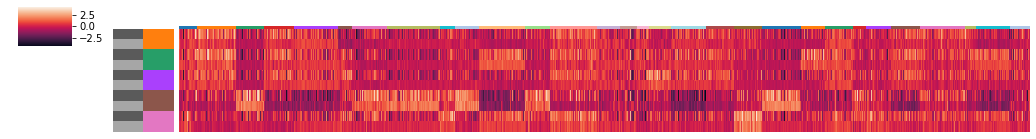

In [237]:
type_color = {'b': '#5a5a5a',
              'p': '#a6a6a6'
             }
cg = sns.clustermap(only_pb_compare, 
                    figsize=(15,3), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    row_colors=[list(map(lambda x: type_color[x], ordered_type)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))],
                    dendrogram_ratio=0.1,
                   );
# plt.tight_layout()
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

## Gene Ontology

Run gene ontology analyses on the modules:

In [239]:
go_files_prefix = '/data/codec/' # just use the same one from the bulk analysis, downloads aint working, probably because of firewall
obo_fname = download_go_basic_obo(go_files_prefix + "go-basic.obo")
fin_gene2go = download_ncbi_associations(go_files_prefix + 'gene2go')

  EXISTS: /data/codec/go-basic.obo
  EXISTS: /data/codec/gene2go


In [240]:
obodag = GODag(go_files_prefix + "go-basic.obo")

/data/codec/go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms


In [241]:
# Read NCBI's gene2go. Store annotations in a list of named tuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.201604 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: /data/codec/gene2go 
MF 17,384 annotated human genes
BP 17,541 annotated human genes
CC 18,648 annotated human genes


In [242]:
gene_ids = list(GeneID2nt_hum.keys())
symbol2geneid = dict(zip([GeneID2nt_hum[i].Symbol for i in gene_ids], [i for i in gene_ids]))

Next cell produces a lot of output, recommend collapsing it in notebook.

In [243]:
results = list()
percent_genes_in_annot = list()
for module in tqdm(main_modules_genes):
    ids = list()

    for i in main_modules_genes[module]:
        try:
            ids.append(symbol2geneid[i])
        except:
            continue
    percent_genes_in_annot.append(len(ids)/len(main_modules_genes[module]))
    
    goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hum.keys(), # List of human protein-coding genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh']) # defult multipletest correction method
    
    goea_results_all = goeaobj.run_study(ids)
    for i in goea_results_all:
        results.append([str(module), i.name, i.NS, -np.log10(i.p_fdr_bh)])


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,711 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,755 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,699 of 20,913 population items found in association

Run BP Gene Ontology Analysis: current study set of 28 IDs ... 82%     23 of     28 study items found in association
100%     28 of     28 study items found in population(20913)
Calculating 12,176 uncorrected p-values using fisher_scipy_stats
  12,176 GO terms are associated with 16,711 of 20,913 population items
     188 GO terms are associated with     23 of     28 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_b

In [244]:
results_df = pd.DataFrame(results, columns=['Module', 'GO_term', 'GO_type', '-log10padj'])

In [245]:
results_df['Module'] = results_df['Module'].astype(np.int)

In [246]:
# with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.results_df.pkl', 'wb') as file:
#     pkl.dump(results_df, file)

In [248]:
with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.results_df.pkl', 'rb') as file:
    results_df = pkl.load(file)

Visualize the significance levels for the terms found in enriched in each module. BP = biological process, MF = molecular function, CC = cellular component.

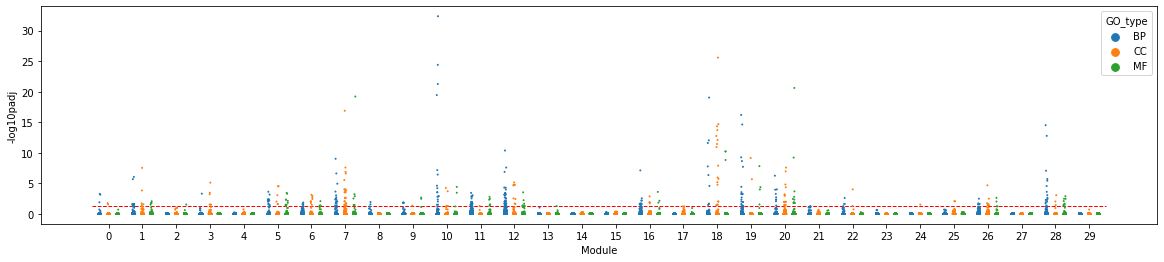

In [249]:
plt.figure(figsize=(20,4))
sns.stripplot(data=results_df,x='Module', hue='GO_type', y='-log10padj', dodge=True, size=2);
plt.plot([-0.5,len(main_modules) - 0.5],[-np.log10(0.05)]*2, linestyle='--', linewidth=1, color='r');

Is the lack of significance from some modules due to the fact that the gene names from that module did not exactly match gene names in the gene ontology dictionary?

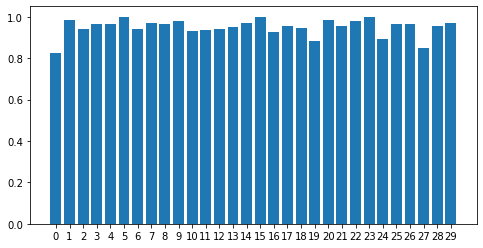

In [250]:
plt.figure(figsize=(8,4))
plt.bar([str(i) for i in main_modules], percent_genes_in_annot);

I think at least 60% of genes is okay.

### Print out and Explore GO Analysis Results

In [251]:
from IPython.display import display # need this to print out the results without truncation.

In [252]:
sig_dfs = dict()
for module in main_modules:
    df = results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                (results_df['Module'] == module)
               ][['GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False)
    sig_dfs[module] = df.copy()

In [253]:
for module in sig_dfs:
    print((module, len(sig_dfs[module])))

(0, 5)
(1, 20)
(2, 1)
(3, 7)
(4, 0)
(5, 26)
(6, 15)
(7, 49)
(8, 2)
(9, 8)
(10, 24)
(11, 29)
(12, 50)
(13, 0)
(14, 0)
(15, 0)
(16, 18)
(17, 0)
(18, 31)
(19, 25)
(20, 35)
(21, 0)
(22, 4)
(23, 0)
(24, 1)
(25, 2)
(26, 15)
(27, 0)
(28, 27)
(29, 0)


In [ ]:
module = 25
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'MF')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'CC')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'BP')].sort_values('-log10padj', ascending=False).head(5))

In [256]:
sig_modules = np.array([0, 1, 3, 5, 6, 7, 9, 10, 11, 12, 16, 18, 19, 20, 22, 26, 28])
# sig_modules = main_modules

In [257]:
len(sig_modules)

17

In [258]:
for module in sig_modules:
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        print(module)
        
#         display(sig_dfs[module][:10])
        
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'MF'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'CC'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'][:5])


0


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
12176,CC,B cell receptor complex,1.746562
12177,CC,external side of plasma membrane,1.554295


,GO_type,GO_term,-log10padj
0,BP,B cell activation,3.269501
1,BP,B cell receptor signaling pathway,3.151307
2,BP,adaptive immune response,1.903115


1


,GO_type,GO_term,-log10padj
31972,MF,carbohydrate binding,2.072404
31973,MF,low-density lipoprotein particle receptor activity,1.790458
31974,MF,complement component C5a receptor activity,1.790458
31975,MF,scavenger receptor activity,1.527502


,GO_type,GO_term,-log10padj
30241,CC,plasma membrane,7.539269
30242,CC,integral component of plasma membrane,3.839954
30243,CC,collagen-containing extracellular matrix,1.724167
30244,CC,specific granule lumen,1.571741
30245,CC,extracellular region,1.436705


,GO_type,GO_term,-log10padj
18065,BP,neutrophil degranulation,6.054388
18066,BP,inflammatory response,5.687059
18067,BP,positive regulation of ERK1 and ERK2 cascade,1.647328
18068,BP,complement receptor mediated signaling pathway,1.624868
18069,BP,positive regulation of cytosolic calcium ion concentration,1.624868


3


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
66371,CC,extracellular exosome,5.118316
66372,CC,lamellipodium,3.462821
66373,CC,focal adhesion,3.215004
66374,CC,extracellular space,1.541534
66375,CC,azurophil granule lumen,1.518369


,GO_type,GO_term,-log10padj
54195,BP,neutrophil degranulation,3.312678


5


,GO_type,GO_term,-log10padj
104232,MF,GTPase activity,3.444001
104233,MF,GTP binding,3.303911
104234,MF,ATPase-coupled peptide transmembrane transporter activity,2.334285
104235,MF,ATPase-coupled peptide antigen transmembrane transporter activity,2.334285
104236,MF,TAP1 binding,2.130498


,GO_type,GO_term,-log10padj
102501,CC,cytoplasmic vesicle,4.530840
102502,CC,symbiont-containing vacuole membrane,4.530840
102503,CC,TAP complex,3.066723
102504,CC,MHC class I peptide loading complex,2.016900
102505,CC,Golgi membrane,1.612278


,GO_type,GO_term,-log10padj
90325,BP,interferon-gamma-mediated signaling pathway,3.623977
90326,BP,cellular response to interferon-gamma,3.167030
90327,BP,lipoprotein metabolic process,2.377157
90328,BP,cytosol to endoplasmic reticulum transport,2.377157
90329,BP,"antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent",2.377157


6


,GO_type,GO_term,-log10padj
122297,MF,protein binding,2.086769
122298,MF,ubiquitin protein ligase binding,1.377504
122299,MF,threonine-type endopeptidase activity,1.377504


,GO_type,GO_term,-log10padj
120566,CC,melanosome,3.123793
120567,CC,"proteasome core complex, alpha-subunit complex",2.945920
120568,CC,cytoplasm,2.685998
120569,CC,I-kappaB/NF-kappaB complex,2.441094
120570,CC,proteasome core complex,2.045984


,GO_type,GO_term,-log10padj
108390,BP,NIK/NF-kappaB signaling,1.872096
108391,BP,apoptotic process,1.633898
108392,BP,MAPK cascade,1.589056
108393,BP,interleukin-1-mediated signaling pathway,1.589056


7


,GO_type,GO_term,-log10padj
140362,MF,RNA binding,19.215433
140363,MF,protein binding,3.223952
140364,MF,box H/ACA snoRNA binding,2.889203
140365,MF,telomerase RNA binding,2.526436
140366,MF,ribosomal small subunit binding,1.467534


,GO_type,GO_term,-log10padj
138631,CC,nucleolus,16.884863
138632,CC,nucleoplasm,7.587271
138633,CC,small nucleolar ribonucleoprotein complex,6.881246
138634,CC,"preribosome, large subunit precursor",6.614380
138635,CC,fibrillar center,5.555156


,GO_type,GO_term,-log10padj
126455,BP,rRNA processing,9.026236
126456,BP,positive regulation of telomerase RNA localization to Cajal body,6.628320
126457,BP,ribosomal large subunit biogenesis,4.948633
126458,BP,ribosomal large subunit assembly,3.654572
126459,BP,rRNA pseudouridine synthesis,3.040920


9


,GO_type,GO_term,-log10padj
176492,MF,tumor necrosis factor receptor binding,2.669828
176493,MF,cytokine activity,2.478530


,GO_type,GO_term,-log10padj
174761,CC,external side of plasma membrane,1.352657


,GO_type,GO_term,-log10padj
162585,BP,immune response,1.837689
162586,BP,negative regulation of interleukin-2 production,1.837689
162587,BP,T cell costimulation,1.837689
162588,BP,positive regulation of T cell chemotaxis,1.837689
162589,BP,positive regulation of endothelial cell apoptotic process,1.772375


10


,GO_type,GO_term,-log10padj
194557,MF,double-stranded RNA binding,4.424153
194558,MF,RNA binding,3.467084


,GO_type,GO_term,-log10padj
192826,CC,cytoplasm,4.244769
192827,CC,cytosol,3.707793
192828,CC,viral replication complex,1.304011
192829,CC,spermatoproteasome complex,1.304011
192830,CC,postsynaptic endocytic zone membrane,1.304011


,GO_type,GO_term,-log10padj
180650,BP,defense response to virus,32.353075
180651,BP,negative regulation of viral genome replication,24.399553
180652,BP,type I interferon signaling pathway,21.259494
180653,BP,response to virus,19.449592
180654,BP,innate immune response,7.171525


11


,GO_type,GO_term,-log10padj
212622,MF,CCR chemokine receptor binding,2.790645
212623,MF,cytokine activity,2.478530
212624,MF,chemokine activity,2.330658
212625,MF,protein tyrosine/threonine phosphatase activity,1.570079
212626,MF,CCR1 chemokine receptor binding,1.445722


,GO_type,GO_term,-log10padj
210891,CC,extracellular space,1.324451


,GO_type,GO_term,-log10padj
198715,BP,monocyte chemotaxis,3.443581
198716,BP,positive regulation of osteoclast differentiation,3.049559
198717,BP,cell-cell signaling,2.879499
198718,BP,lymphocyte chemotaxis,2.835367
198719,BP,positive regulation of cell population proliferation,2.835367


12


,GO_type,GO_term,-log10padj
230687,MF,RAGE receptor binding,3.530210
230688,MF,zinc ion binding,2.243096
230689,MF,MHC class Ib protein complex binding,1.676750
230690,MF,chemokine activity,1.373919
230691,MF,MHC class I protein binding,1.349255


,GO_type,GO_term,-log10padj
228956,CC,ficolin-1-rich granule membrane,5.155727
228957,CC,extracellular space,4.779381
228958,CC,cell,4.779381
228959,CC,plasma membrane,4.677432
228960,CC,extracellular region,4.677432


,GO_type,GO_term,-log10padj
216780,BP,inflammatory response,10.374873
216781,BP,neutrophil degranulation,7.590071
216782,BP,neutrophil chemotaxis,6.880803
216783,BP,positive regulation of inflammatory response,4.302397
216784,BP,cellular response to zinc ion,4.302397


16


,GO_type,GO_term,-log10padj
302947,MF,CXCR3 chemokine receptor binding,3.604375
302948,MF,"indoleamine 2,3-dioxygenase activity",2.152109
302949,MF,"tryptophan 2,3-dioxygenase activity",1.851592


,GO_type,GO_term,-log10padj
301216,CC,external side of plasma membrane,2.868896
301217,CC,postsynapse,1.902185
301218,CC,cell,1.902185
301219,CC,extracellular space,1.741706


,GO_type,GO_term,-log10padj
289040,BP,immune response,7.123279
289041,BP,"complement activation, classical pathway",2.552875
289042,BP,regulation of complement activation,2.183762
289043,BP,negative regulation of interleukin-10 production,2.183762
289044,BP,signal transduction,1.724102


18


,GO_type,GO_term,-log10padj
339077,MF,peptide antigen binding,10.226774
339078,MF,MHC class II receptor activity,10.226774
339079,MF,MHC class II protein complex binding,8.826265


,GO_type,GO_term,-log10padj
337346,CC,MHC class II protein complex,25.583620
337347,CC,integral component of lumenal side of endoplasmic reticulum membrane,14.689102
337348,CC,lysosomal membrane,14.334737
337349,CC,clathrin-coated endocytic vesicle membrane,13.720320
337350,CC,transport vesicle membrane,12.761128


,GO_type,GO_term,-log10padj
325170,BP,antigen processing and presentation of exogenous peptide antigen via MHC class II,19.044685
325171,BP,adaptive immune response,12.050016
325172,BP,interferon-gamma-mediated signaling pathway,11.603787
325173,BP,immune response,7.774353
325174,BP,T cell receptor signaling pathway,6.356586


19


,GO_type,GO_term,-log10padj
357142,MF,cytokine activity,7.819901
357143,MF,interleukin-1 receptor binding,4.377344
357144,MF,chemokine activity,3.994894
357145,MF,growth factor activity,1.551934


,GO_type,GO_term,-log10padj
355411,CC,extracellular space,9.156298
355412,CC,extracellular region,5.679305


,GO_type,GO_term,-log10padj
343235,BP,cellular response to lipopolysaccharide,16.204852
343236,BP,cytokine-mediated signaling pathway,14.634797
343237,BP,neutrophil chemotaxis,9.256432
343238,BP,inflammatory response,8.652510
343239,BP,leukocyte chemotaxis,7.714752


20


,GO_type,GO_term,-log10padj
375207,MF,RNA binding,20.618881
375208,MF,unfolded protein binding,9.226947
375209,MF,protein binding,3.689588
375210,MF,protein folding chaperone,2.793831
375211,MF,double-stranded RNA binding,2.449415


,GO_type,GO_term,-log10padj
373476,CC,nucleolus,7.587924
373477,CC,cytosol,6.965517
373478,CC,chaperonin-containing T-complex,4.812395
373479,CC,nucleoplasm,4.364031
373480,CC,membrane,3.211791


,GO_type,GO_term,-log10padj
361300,BP,protein folding,6.253627
361301,BP,positive regulation of protein localization to Cajal body,4.009814
361302,BP,positive regulation of establishment of protein localization to telomere,3.965187
361303,BP,positive regulation of telomerase RNA localization to Cajal body,3.282867
361304,BP,response to unfolded protein,2.716428


22


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
409606,CC,T cell receptor complex,4.014573


,GO_type,GO_term,-log10padj
397430,BP,adaptive immune response,2.613451
397431,BP,positive regulation of T cell receptor signaling pathway,1.625888
397432,BP,nuclear migration along microfilament,1.625888


26


,GO_type,GO_term,-log10padj
483597,MF,protein binding,2.623798
483598,MF,identical protein binding,2.023561


,GO_type,GO_term,-log10padj
481866,CC,extracellular exosome,4.682140
481867,CC,cytosol,2.498948
481868,CC,focal adhesion,1.752291
481869,CC,membrane,1.613679
481870,CC,cell tip,1.503253


,GO_type,GO_term,-log10padj
469690,BP,positive regulation of transcription by RNA polymerase II,2.493067
469691,BP,negative regulation of apoptotic process,1.727172
469692,BP,positive regulation of apoptotic process,1.628346
469693,BP,platelet degranulation,1.567151
469694,BP,negative regulation of extrinsic apoptotic signaling pathway via death domain receptors,1.543320


28


,GO_type,GO_term,-log10padj
519727,MF,ubiquitin-like protein ligase binding,2.894766
519728,MF,tumor necrosis factor receptor binding,2.479352
519729,MF,identical protein binding,2.479352
519730,MF,protein binding,2.105008
519731,MF,TAP2 binding,1.681113


,GO_type,GO_term,-log10padj
517996,CC,cytosol,3.058735
517997,CC,cytoplasm,2.031260
517998,CC,early endosome membrane,1.453949


,GO_type,GO_term,-log10padj
505820,BP,defense response to virus,14.523925
505821,BP,type I interferon signaling pathway,12.776711
505822,BP,interferon-gamma-mediated signaling pathway,7.069837
505823,BP,response to virus,5.721728
505824,BP,innate immune response,5.430915


In [ ]:
for module in sig_modules:
    print(module)
    print(sig_dfs[module][sig_dfs[module]['GO_term'].str.contains('cAMP')])

In [ ]:
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'])

In [260]:
dfs = list()
for sig_module in sig_modules:
    dfs.append(results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                          (results_df['Module'] == sig_module)
                         ][['Module', 'GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False))

In [261]:
pd.concat(dfs).to_csv(prefix + 'go.analysis/kmeans.modules/kmeans.n30.sig.modules.GO.csv')

### Label the Significant Modules

In [337]:
sig_module_labels = {
    1: 'cytokine',
    2: 'neutrophil degranulation',
    6: 'virus',
    8: 'metal ion metabolism',
    10: 'LPS response',
    19: 'cAMP response',
    41: 'MHC binding'
}

In [338]:
len(sig_modules)

7

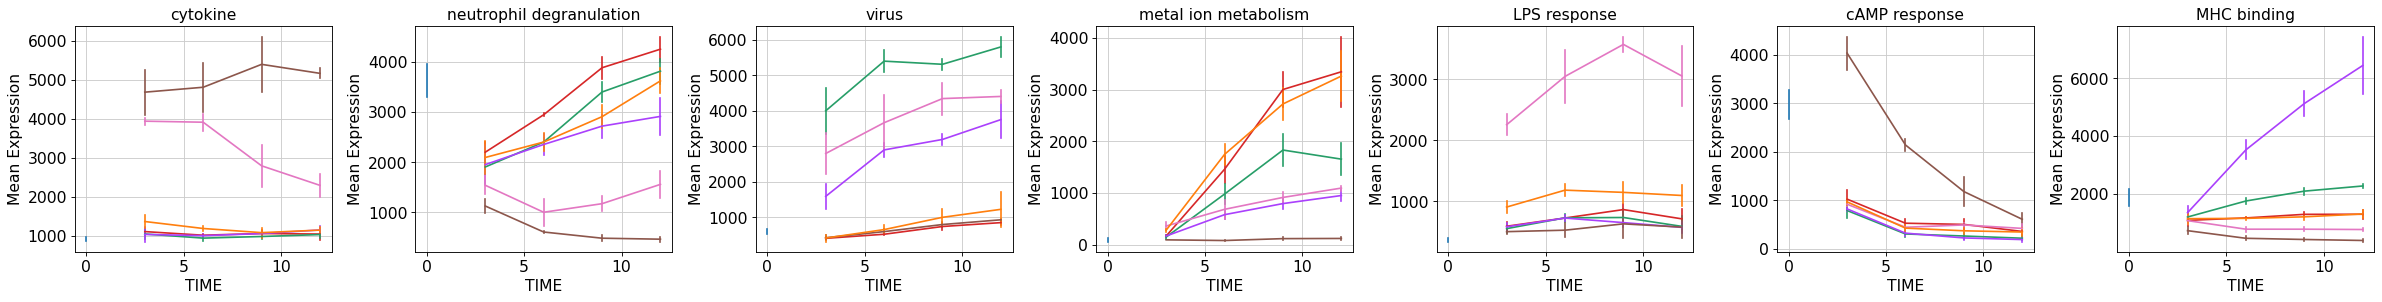

In [339]:
fig, ax = plt.subplots(1, 7, figsize=(30,4))
for sig_module, ax in zip(sig_modules, np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm'][main_modules_genes[sig_module]]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(str(sig_module_labels[sig_module]))
    ax.get_legend().remove()
plt.tight_layout()

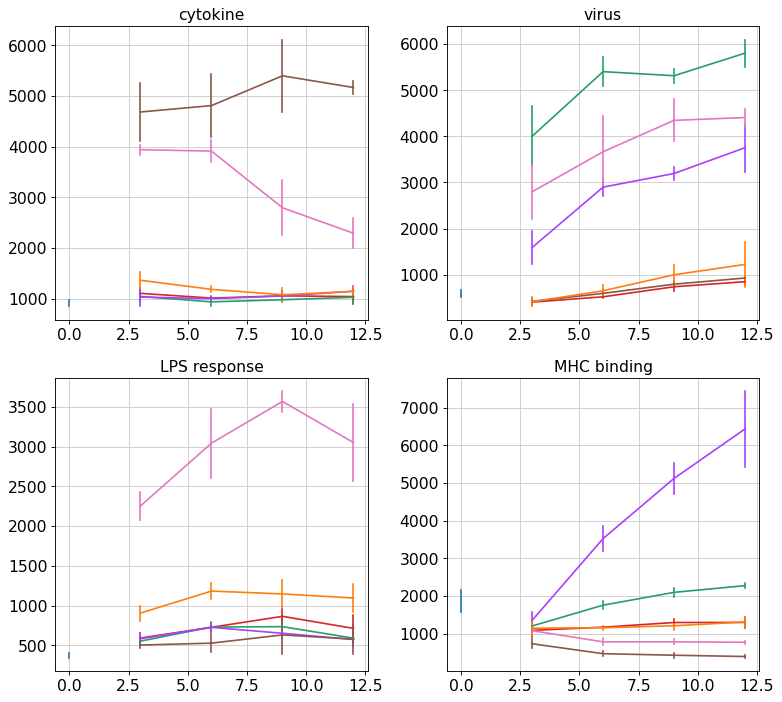

In [347]:
fig, ax = plt.subplots(2, 2, figsize=(10,9))
for sig_module, ax in zip([1, 6, 10, 41], np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm'][main_modules_genes[sig_module]]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(str(sig_module_labels[sig_module]))
    ax.get_legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)
plt.tight_layout()

# Extra

Using the 90th percentile positive log2fc and the p_adj < 0.01, I will now extract out differentially expressed genes.

In [9]:
de_genes = dict() # make a dictionary

for cond in conds_1: # this has all the conditions
    de_genes[cond] = dict() # each value will be each cond, itself be a dictionary with values of cts

In [10]:
# for each cond, each non-zero ct...
combos = list(it.product(conds_1, cts_1)) 
for combo in combos: 
    cond = combo[0]
    ct = combo[1]
    df = de[cond][ct] # get the DE results
    
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    
    # It was in this moment that I realized, the myeloid PMA/I cells also probably capture the cDCs, and
    # therefore they also shouldn't be included in the cDC cell types either, and perhaps Mono_Other_PMA
    # is a misnomer and it should probably be Myeloid_Other_PMA
    # It was for this reason that the log2FoldChange ended up being all negative probably because
    # there was only a handful of cells in the PMAI condition in cDCs
    # therefore, running a check right now to make sure the df isn't empty after subsetting for positive
    # values, but I should go back to the explore.cts notebook when I made the pseuodobulks and reaccount for this
    
    if len(df) == 0:
        continue
    
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct]['-log10padj'] = -np.log10(de_genes[cond][ct]['padj'])

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# for each cond, each non-zero ct...
combos = list(it.product(conds_2, cts_2)) 
for combo in tqdm(combos): 
    cond = combo[0]
    ct = combo[1]
    df = de[cond][ct] # get the DE results
    
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    
    # It was in this moment that I realized, the myeloid PMA/I cells also probably capture the cDCs, and
    # therefore they also shouldn't be included in the cDC cell types either, and perhaps Mono_Other_PMA
    # is a misnomer and it should probably be Myeloid_Other_PMA
    # It was for this reason that the log2FoldChange ended up being all negative probably because
    # there was only a handful of cells in the PMAI condition in cDCs
    # therefore, running a check right now to make sure the df isn't empty after subsetting for positive
    # values, but I should go back to the explore.cts notebook when I made the pseuodobulks and reaccount for this
    
    if len(df) == 0:
        continue
    
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct]['-log10padj'] = -np.log10(de_genes[cond][ct]['padj'])

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
num_genes = pd.DataFrame(index=conds_1, columns=cts_1)
for cond in conds_1:
    for ct in cts_1:
        num_genes.loc[cond, ct] = len(de_genes[cond][ct])

In [13]:
num_genes

,B_Memory,B_Naive,CD4_T_Memory,CD4_T_Naive,CD8_T_Memory_MAIT_GD,CD8_T_Naive,HSC,NK,pDC,Mono_cDC_All
A,0,0,3,58,8,10,45,8,135,392
B,502,609,396,706,460,251,79,480,651,493
G,106,157,21,287,0,61,52,0,0,653
P,880,666,442,808,591,790,232,474,408,1001
R,888,926,547,839,613,330,169,585,842,656


In [14]:
num_genes = pd.DataFrame(index=conds_2, columns=cts_2)
for cond in conds_2:
    for ct in cts_2:
        num_genes.loc[cond, ct] = len(de_genes[cond][ct])

In [15]:
num_genes

,Mono_C,Mono_NC,cDC
A,328,48,118
B,477,446,676
G,661,332,484
R,588,425,406


In [16]:
ct_specific_de_genes = dict()

In [17]:
for cond in tqdm(conds_1):
    cond_cts = list(de_genes[cond].keys())
    ct_specific_de_genes[cond] = dict()
    for ct in cond_cts:
        other_ct_de_genes_map = map(lambda ct: de_genes[cond][ct].index.values, [i for i in cond_cts if i != ct])
        other_ct_de_genes = np.unique([i for j in other_ct_de_genes_map for i in j])
        ct_specific_de_genes[cond][ct] = de_genes[cond][ct].loc[np.setdiff1d(de_genes[cond][ct].index.values, other_ct_de_genes)]

In [18]:
num_genes = pd.DataFrame(index=conds_1, columns=cts_1)
for cond in conds_1:
    for ct in cts_1:
        num_genes.loc[cond, ct] = len(ct_specific_de_genes[cond][ct])

In [19]:
num_genes

,B_Memory,B_Naive,CD4_T_Memory,CD4_T_Naive,CD8_T_Memory_MAIT_GD,CD8_T_Naive,HSC,NK,pDC,Mono_cDC_All
A,0,0,0,39,0,0,27,0,104,39
B,31,76,4,143,22,0,2,40,363,8
G,5,16,0,80,0,0,4,0,0,20
P,131,38,11,50,21,51,43,20,150,816
R,104,198,22,145,41,0,6,47,341,29


In [20]:
num_genes = pd.DataFrame(index=conds_2, columns=cts_2)
for cond in conds_2:
    for ct in cts_2:
        num_genes.loc[cond, ct] = len(ct_specific_de_genes[cond][ct])

In [21]:
num_genes

,Mono_C,Mono_NC,cDC
A,5,1,26
B,4,37,127
G,36,38,131
R,3,48,39


In [22]:
de_genes['B']['CD8_T_Memory_MAIT_GD'].sort_values(by='-log10padj', ascending=False)[:20]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10padj
IFIT1,90.366365,4.252715,0.180466,23.565230,8.763288e-123,9.163770e-119,118.037926
IFI6,267.951834,4.325477,0.194701,22.215973,2.407132e-109,1.258569e-105,104.900123
IFIT3,98.862932,4.166066,0.189302,22.007509,2.440392e-107,6.379794e-104,103.195193
RSAD2,54.178603,4.139642,0.188009,22.018350,1.921331e-107,6.379794e-104,103.195193
IFI44L,48.280330,3.950867,0.180428,21.897197,2.762600e-106,5.777702e-103,102.238245
IFIT2,74.719979,3.992685,0.186350,21.425717,7.694150e-102,1.340962e-98,97.872584
MX1,148.391317,3.934166,0.190032,20.702701,3.274925e-95,4.892270e-92,91.310490
OAS3,23.196968,3.748438,0.183734,20.401463,1.622855e-92,2.121274e-89,88.673403
CMPK2,23.917225,3.570004,0.175711,20.317417,9.019903e-92,1.048012e-88,87.979634
HERC5,61.215823,3.596894,0.178918,20.103556,6.869064e-90,7.182981e-87,86.143695
